# Digital homo- and heterodyne detection

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

from qutip import *
from scipy.interpolate import interp1d
from scipy.stats import kstest

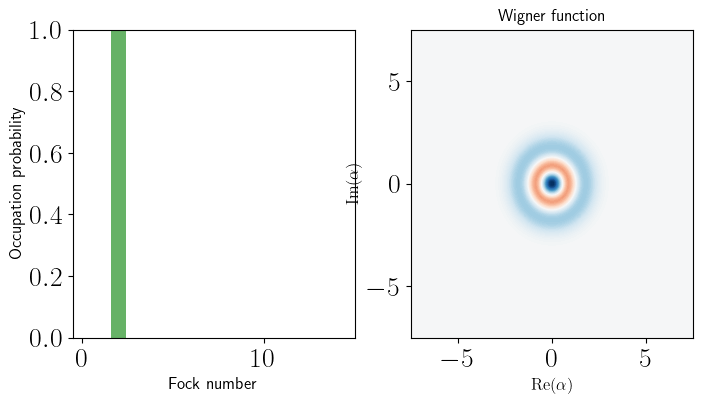

In [2]:
N=15

idc = qeye(N)
ida = qeye(2)
a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2))
sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# cavity photon number operator
N_cav = tensor(num(N), ida)

# projection operators to qubit ground and excited state
proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())


initial_cavity = coherent(N, 1j*1)

initial_cavity = fock(N,2) 

alpha = 2
#initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#initial_cavity = (fock(N, 1) + fock(N,2)).unit()

psi0 = tensor(initial_cavity, basis(2,0))

n_init = expect(N_cav, psi0)

plot_wigner_fock_distribution(initial_cavity);

In [3]:
def U_interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

## Qubit-dyne params

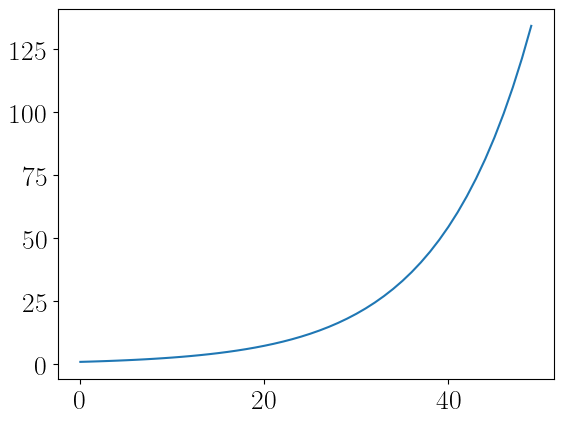

In [4]:
Nmeas = 50

g = 0.25
gamma = g**2
dt = 0.5

nsteps = np.linspace(0,Nmeas-1,Nmeas)
tlist = nsteps*dt

expspeed=0.1

def g_timedep(i):
    #return (i/5)
    #return  2/(1 + np.exp(-0.2*(i-20)))
    return np.exp(expspeed*(i))
    #return i/18
    #return np.log10(i)

g_timedep_list = np.array([g_timedep(i) for i in range(Nmeas)])

U_ints=[]
for i in range(Nmeas):
    U_ints.append(U_interact(g*g_timedep_list[i]*np.sqrt(dt)))
    
plt.plot(g_timedep(nsteps));

## Run simulation to extract weights

In [5]:
# Select quadrature
rotangl = 0
qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

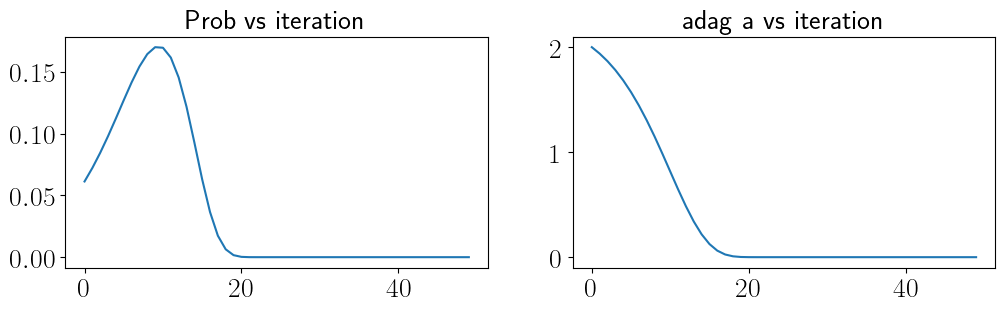

In [6]:
# Find weights by solving unconditional ME

p1exp = []
n_cav = []
rho = ket2dm(psi0)

expect_a = []

for i in range(Nmeas):
    
    n_cav.append(expect(N_cav, rho))
    U_int = U_ints[i]
    rho = U_int * rho * U_int.dag()
    
    p1val= expect(proj1, rho)
    p1exp.append(p1val)
    
    expect_a.append(expect(a,rho))
    
    rho = tensor(rho.ptrace(0),basis(2,0).proj())
    
## Define weights based on scaled qubit excitation probability
weights=np.sqrt(np.array(p1exp)/(2*n_init))

fig, axes = plt.subplots(1, 2, figsize=(12,3))

axes[0].plot(p1exp)
lbl2 = axes[0].set_title("Prob vs iteration")

axes[1].plot(n_cav)
lbl2 = axes[1].set_title("adag a vs iteration")
plt.show()

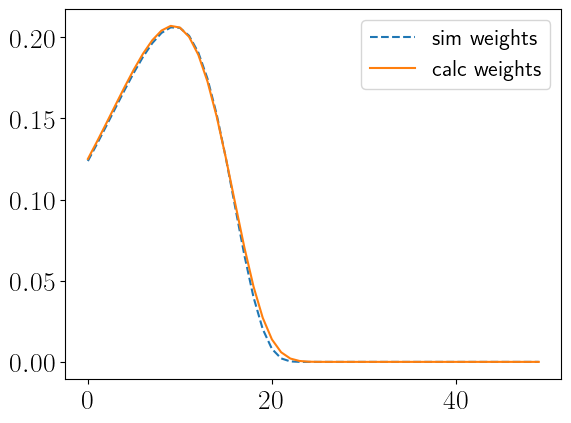

In [7]:
plt.plot(weights,'--', label='sim weights')

def calc_weights(step):
    g_timedep_list = np.array([g_timedep(i) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return  g_timedep(step)*np.sqrt(gamma*dt/2)*np.exp(-gamma*exponent/2)

calculated_weights = np.array([calc_weights(step) for step in range(Nmeas)])

plt.plot(calculated_weights, label='calc weights')
plt.legend();

## compare simulated cavity decay with ME solution

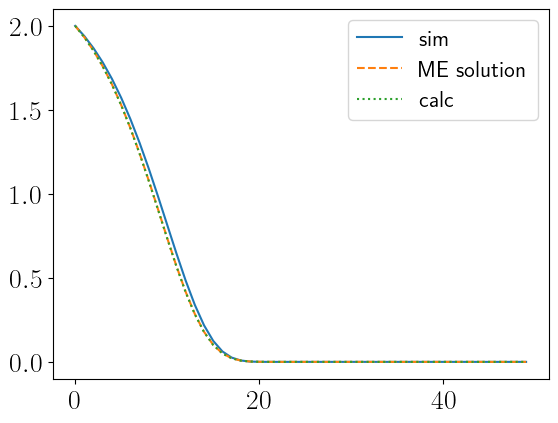

In [8]:
H_int = [(-1j) * g*np.sqrt(dt)*angle * (a.dag() * sm + a * sm.dag()) for angle in g_timedep_list]

c_op=[[a,g*g_timedep_list]] # decay rate gamma
opts = Options(nsteps=10000)

sol = mesolve(0*a, psi0, nsteps*dt, c_ops=c_op, e_ops=[N_cav], options=opts)

plt.plot(n_cav, label = 'sim')
plt.plot(nsteps, sol.expect[0], '--',label='ME solution')
#plt.plot(test, ':', label='test')
#plt.plot(alpharef**2 * np.exp(-(tlist*g)**2/5), label='meh')
#plt.plot(1/(gamma*dt)*pe,':')
#plt.plot(n_init*np.exp(-gamma*dt*nsteps), ':',label='linear analytic')

def calc_decay(step):
    g_timedep_list = np.array([g_timedep(i) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return n_init*np.exp(-gamma*exponent)

calculated_decay = np.array([calc_decay(step) for step in range(Nmeas)])
#test /=  np.max(test)#np.trapz(test**2,dx=dt)
#test = alpharef**2*test
plt.plot(calculated_decay,':' ,label='calc')

plt.legend();

### plot simulated and calculated qubit excitation probability

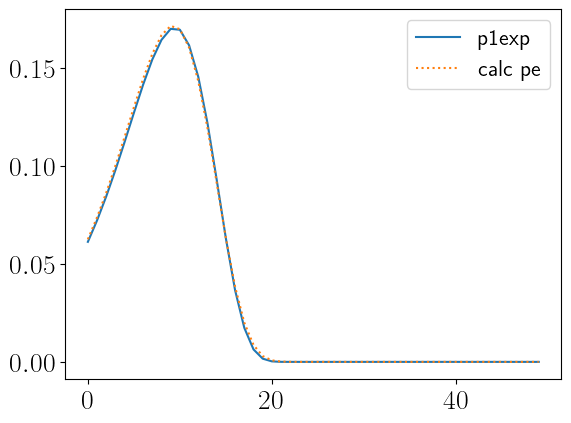

In [9]:
plt.plot(p1exp, label='p1exp')
#calc = (g*g_timedep_list)**2*dt*np.array(n_cav)

#plt.plot(calc, label='calc')

pe = g**2*dt*n_init*np.exp(-gamma*dt*nsteps)

plt.plot((g*g_timedep_list)**2*dt*calculated_decay,':', label='calc pe')
plt.legend();

## Get histogram

In [ ]:
# Repeated homodyne detection: calculate single homodyne shots and collect statistics
Ntrajs = 1000

measurements = []

for j in range(Ntrajs):
    xrnd = np.random.rand(Nmeas)
    
    results = []
    psi = psi0

    for i in range(Nmeas):
        psi = qbrotmat * (U_ints[i] * psi)

        prob = expect(proj0,psi)
        if prob>xrnd[i]:
            # measured g
            results.append(-1)
            psi = (proj0 * psi).unit()
        else:
            results.append(1)
            # measured e
            psi = (proj1 * psi).unit()
            # go back to g
            psi = qbfeedback * psi
    
    measurements.append(np.sum(results*weights))

In [ ]:
k=5
plt.hist(np.array(measurements),60,[-k,k],density=True)

x=np.linspace(-k,k,500)
#plt.plot(x, np.abs((2/np.sqrt(2))*np.exp(-x**2/2)*(1/np.pi)**(1/4)*x)**2) # 1 photon
#plt.plot(x, np.abs(np.exp(-(x - 1*1.41)**2/2)*(1/np.pi)**(1/4))**2)

# ideal distribution from Wigner marginal
x=np.linspace(-5,5,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0)
plt.plot(x, marginal)

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

ks_stat = kstest(measurements, cdf_func)[0]
ks_stat